[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/KirkCorwin/CatanBlue/blob/gan/Kirk/mini_catan_gan.ipynb)  

### Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
CLASS_NAMES = [
    "Desert",
    "Field",
    "Forest",
    "Hill",
    "Mountain",
    "Pasture",
    "Sea"
]

class_to_idx = {name: idx for idx, name in enumerate(CLASS_NAMES)}
idx_to_class = {idx: name for name, idx in class_to_idx.items()}

NUM_CLASSES = len(CLASS_NAMES)

print(class_to_idx)

{'Desert': 0, 'Field': 1, 'Forest': 2, 'Hill': 3, 'Mountain': 4, 'Pasture': 5, 'Sea': 6}


In [ ]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

DATA_DIR = "/content/drive/MyDrive/datasets/main7_128"

transform = transforms.Compose([
    transforms.Resize((128, 128)),   # safety
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.5, 0.5, 0.5],
        std=[0.5, 0.5, 0.5]
    )
])

dataset = datasets.ImageFolder(
    root=DATA_DIR,
    transform=transform
)

# Override ImageFolder’s internal class mapping (important)
dataset.class_to_idx = class_to_idx

dataloader = DataLoader(
    dataset,
    batch_size=64,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

print(f"Loaded {len(dataset)} images across {NUM_CLASSES} classes")

Loaded 447 images across 7 classes


### Define Autoencoder

In [ ]:
import torch
import torch.nn as nn

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

NUM_CLASSES = 7
CLASS_EMBED_DIM = 16     # small, strong conditioning
LATENT_DIM = 128         # shared latent for GAN later

In [ ]:
# just reduce to 32 x 32
class Encoder(nn.Module):
    def __init__(self, in_ch=3, z_ch=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_ch, 32, 4, 2, 1),   # 128 → 64
            nn.ReLU(),
            nn.Conv2d(32, z_ch, 4, 2, 1),    # 64 → 32
            nn.ReLU()
        )

    def forward(self, x):
        return self.net(x)  # (B, z_ch, 32, 32)

In [ ]:
# no upsampling
class Decoder(nn.Module):
    def __init__(self, z_ch=64, out_ch=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(z_ch, 64, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(64, out_ch, 3, 1, 1),
            nn.Tanh()
        )

    def forward(self, z, c):
        return self.net(z)  # (B, 3, 32, 32)

In [ ]:
class ClassConditionedAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.class_emb = nn.Embedding(NUM_CLASSES, CLASS_EMBED_DIM)
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x, labels):
        z = self.encoder(x)
        c = self.class_emb(labels)
        recon = self.decoder(z, c)
        return recon, z

In [ ]:
# Recreate the autoencoder with the new architecture
model = ClassConditionedAutoencoder().to(DEVICE)

# Standard training setup
criterion = nn.MSELoss()       # pixel reconstruction
optimizer = torch.optim.Adam(model.parameters(), lr=2e-4)

### Train Autoencoder

In [ ]:
EPOCHS = 80

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for imgs, labels in dataloader:
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)

        # Downsample target to 32×32
        target = nn.functional.interpolate(
            imgs, size=(32, 32), mode="bilinear"
        )

        optimizer.zero_grad()
        recon, _ = model(imgs, labels)
        loss = criterion(recon, target)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {total_loss / len(dataloader):.4f}")

Epoch 1/80 | Loss: 0.3922
Epoch 2/80 | Loss: 0.2872
Epoch 3/80 | Loss: 0.1681
Epoch 4/80 | Loss: 0.0946
Epoch 5/80 | Loss: 0.0723
Epoch 6/80 | Loss: 0.0607
Epoch 7/80 | Loss: 0.0550
Epoch 8/80 | Loss: 0.0477
Epoch 9/80 | Loss: 0.0421
Epoch 10/80 | Loss: 0.0370
Epoch 11/80 | Loss: 0.0321
Epoch 12/80 | Loss: 0.0280
Epoch 13/80 | Loss: 0.0249
Epoch 14/80 | Loss: 0.0225
Epoch 15/80 | Loss: 0.0209
Epoch 16/80 | Loss: 0.0195
Epoch 17/80 | Loss: 0.0182
Epoch 18/80 | Loss: 0.0170
Epoch 19/80 | Loss: 0.0160
Epoch 20/80 | Loss: 0.0150
Epoch 21/80 | Loss: 0.0141
Epoch 22/80 | Loss: 0.0132
Epoch 23/80 | Loss: 0.0124
Epoch 24/80 | Loss: 0.0117
Epoch 25/80 | Loss: 0.0111
Epoch 26/80 | Loss: 0.0105
Epoch 27/80 | Loss: 0.0100
Epoch 28/80 | Loss: 0.0095
Epoch 29/80 | Loss: 0.0091
Epoch 30/80 | Loss: 0.0087
Epoch 31/80 | Loss: 0.0083
Epoch 32/80 | Loss: 0.0080
Epoch 33/80 | Loss: 0.0077
Epoch 34/80 | Loss: 0.0075
Epoch 35/80 | Loss: 0.0072
Epoch 36/80 | Loss: 0.0070
Epoch 37/80 | Loss: 0.0068
Epoch 38/8

In [ ]:
# Freeze the autoencoder

model.eval()
for p in model.parameters():
    p.requires_grad = False

### Set up GAN

In [ ]:
# Gan hyperparameters

LATENT_DIM = 128
NUM_CLASSES = 7
CLASS_EMBED_DIM = 16

In [ ]:
# latent to latent generator

class LatentGenerator(nn.Module):
    def __init__(self):
        super().__init__()

        self.class_emb = nn.Embedding(NUM_CLASSES, CLASS_EMBED_DIM)

        self.model = nn.Sequential(
            nn.Linear(LATENT_DIM + CLASS_EMBED_DIM, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 64 * 32 * 32)  # Output same as encoder: 65,536
        )

    def forward(self, z, labels):
        c = self.class_emb(labels)
        x = torch.cat([z, c], dim=1)
        out = self.model(x)
        return out.view(-1, 64, 32, 32)  # Reshape to (B, 64, 32, 32)

In [ ]:
# latent vs fake discriminator

class LatentDiscriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.class_emb = nn.Embedding(NUM_CLASSES, CLASS_EMBED_DIM)

        self.model = nn.Sequential(
            nn.Linear(64 * 32 * 32 + CLASS_EMBED_DIM, 256),  # Accept flattened spatial
            nn.LeakyReLU(0.2),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 1)
        )

    def forward(self, z, labels):
        # z is (B, 64, 32, 32), need to flatten it
        z_flat = z.view(z.size(0), -1)  # (B, 65536)
        c = self.class_emb(labels)
        x = torch.cat([z_flat, c], dim=1)
        return self.model(x)

In [ ]:
criterion = nn.BCEWithLogitsLoss()

G = LatentGenerator().to(DEVICE)
D = LatentDiscriminator().to(DEVICE)

opt_G = torch.optim.Adam(G.parameters(), lr=2e-4, betas=(0.5, 0.999))
opt_D = torch.optim.Adam(D.parameters(), lr=2e-4, betas=(0.5, 0.999))

In [ ]:
with torch.no_grad():
    real_z = model.encoder(imgs)

### Train GAN

##### Reduce epochs to reduce training time (upwards of 2 hours for 2k epochs)

In [ ]:
EPOCHS = 2000

In [30]:
import os
import torch
import torchvision.utils as vutils

# checkpoint paths
checkpoint_dir = '/content/drive/MyDrive/checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

gen_checkpoint = os.path.join(checkpoint_dir, 'generator.pth')
disc_checkpoint = os.path.join(checkpoint_dir, 'discriminator.pth')
training_state = os.path.join(checkpoint_dir, 'training_state.pth')

# examples directory
examples_dir = os.path.join(checkpoint_dir, 'examples')
os.makedirs(examples_dir, exist_ok=True)

# load checkpoint if exists
start_epoch = 0
if os.path.exists(training_state):
    checkpoint = torch.load(training_state, map_location=DEVICE)
    G.load_state_dict(checkpoint['generator_state'])
    D.load_state_dict(checkpoint['discriminator_state'])
    opt_G.load_state_dict(checkpoint['optimizer_G_state'])
    opt_D.load_state_dict(checkpoint['optimizer_D_state'])
    start_epoch = checkpoint['epoch']
    print(f"resumed from epoch {start_epoch}")
else:
    print("starting training from scratch")

# training loop
for epoch in range(start_epoch, EPOCHS):
    for imgs, labels in dataloader:
        imgs = imgs.to(DEVICE)
        labels = labels.to(DEVICE)
        batch = imgs.size(0)

        valid = torch.ones(batch, 1, device=DEVICE) * 0.9
        fake = torch.zeros(batch, 1, device=DEVICE)

        # train discriminator
        opt_D.zero_grad()
        with torch.no_grad():
            real_z = model.encoder(imgs)
        noise = torch.randn(batch, LATENT_DIM, device=DEVICE)
        fake_z = G(noise, labels)

        real_loss = criterion(D(real_z, labels), valid)
        fake_loss = criterion(D(fake_z.detach(), labels), fake)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        opt_D.step()

        # train generator
        opt_G.zero_grad()
        gen_loss = criterion(D(fake_z, labels), valid)
        gen_loss.backward()
        opt_G.step()

    print(f"epoch {epoch+1}/{EPOCHS} | D: {d_loss.item():.3f} | G: {gen_loss.item():.3f}")

    # save checkpoint
    torch.save({
        'epoch': epoch + 1,
        'generator_state': G.state_dict(),
        'discriminator_state': D.state_dict(),
        'optimizer_G_state': opt_G.state_dict(),
        'optimizer_D_state': opt_D.state_dict(),
    }, training_state)

    torch.save(G.state_dict(), gen_checkpoint)
    torch.save(D.state_dict(), disc_checkpoint)

    # save example images
    if (epoch < 50 and (epoch + 1) % 10 == 0) or (epoch >= 50 and (epoch + 1) % 50 == 0):
        epoch_dir = os.path.join(examples_dir, f'epoch_{epoch+1}')
        os.makedirs(epoch_dir, exist_ok=True)

        G.eval()
        with torch.no_grad():
            for cls in range(NUM_CLASSES):
                class_dir = os.path.join(epoch_dir, f"class_{cls}")
                os.makedirs(class_dir, exist_ok=True)

                noise = torch.randn(3, LATENT_DIM, device=DEVICE)
                labels = torch.full((3,), cls, dtype=torch.long, device=DEVICE)

                samples = model.decoder(G(noise, labels), model.class_emb(labels))
                for i, img in enumerate(samples):
                    path = os.path.join(class_dir, f"{i}.png")
                    vutils.save_image((img + 1)/2, path)

        G.train()

print("training complete, checkpoints saved")


resumed from epoch 1000
epoch 1001/2000 | D: 0.399 | G: 1.771
epoch 1002/2000 | D: 0.336 | G: 2.409
epoch 1003/2000 | D: 0.337 | G: 2.248
epoch 1004/2000 | D: 0.488 | G: 1.634
epoch 1005/2000 | D: 0.373 | G: 2.375
epoch 1006/2000 | D: 0.386 | G: 1.674
epoch 1007/2000 | D: 0.392 | G: 2.043
epoch 1008/2000 | D: 0.386 | G: 2.601
epoch 1009/2000 | D: 0.438 | G: 2.426
epoch 1010/2000 | D: 0.371 | G: 1.595
epoch 1011/2000 | D: 0.395 | G: 2.527
epoch 1012/2000 | D: 0.476 | G: 2.664
epoch 1013/2000 | D: 0.356 | G: 2.108
epoch 1014/2000 | D: 0.337 | G: 2.056
epoch 1015/2000 | D: 0.414 | G: 1.699
epoch 1016/2000 | D: 0.348 | G: 1.969
epoch 1017/2000 | D: 0.403 | G: 1.826
epoch 1018/2000 | D: 0.450 | G: 1.391
epoch 1019/2000 | D: 0.373 | G: 2.397
epoch 1020/2000 | D: 0.421 | G: 2.918
epoch 1021/2000 | D: 0.463 | G: 1.142
epoch 1022/2000 | D: 0.414 | G: 2.163
epoch 1023/2000 | D: 0.391 | G: 1.789
epoch 1024/2000 | D: 0.386 | G: 1.771
epoch 1025/2000 | D: 0.443 | G: 1.448
epoch 1026/2000 | D: 0.375

### Demonstration: generate tiles for each class

In [31]:
G.eval()
model.eval()

labels = torch.tensor([0,1,2,3,4,5,6], device=DEVICE)
noise = torch.randn(len(labels), LATENT_DIM, device=DEVICE)

with torch.no_grad():
    z = G(noise, labels)
    c = model.class_emb(labels)
    tiles = model.decoder(z, c)

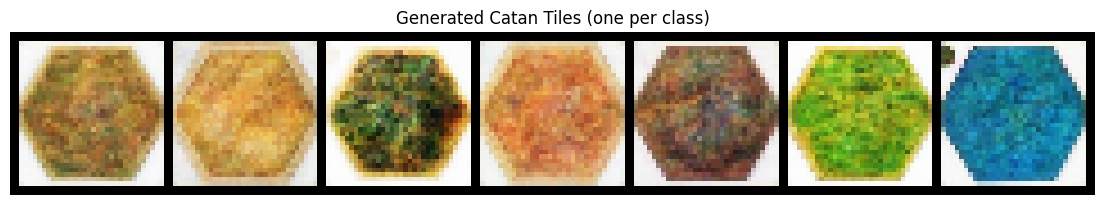

In [32]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

G.eval()
model.eval()

# One tile per class
labels = torch.tensor([0,1,2,3,4,5,6], device=DEVICE)
noise = torch.randn(len(labels), LATENT_DIM, device=DEVICE)

with torch.no_grad():
    z = G(noise, labels)
    c = model.class_emb(labels)
    tiles = model.decoder(z, c)  # (N, 3, 32, 32)

# Convert from [-1,1] -> [0,1] for display
tiles = (tiles + 1) / 2
tiles = tiles.clamp(0, 1)

# Make grid (one row)
grid = make_grid(tiles, nrow=len(labels), padding=2)

plt.figure(figsize=(14, 3))
plt.imshow(grid.permute(1, 2, 0).cpu())
plt.axis("off")
plt.title("Generated Catan Tiles (one per class)")
plt.show()

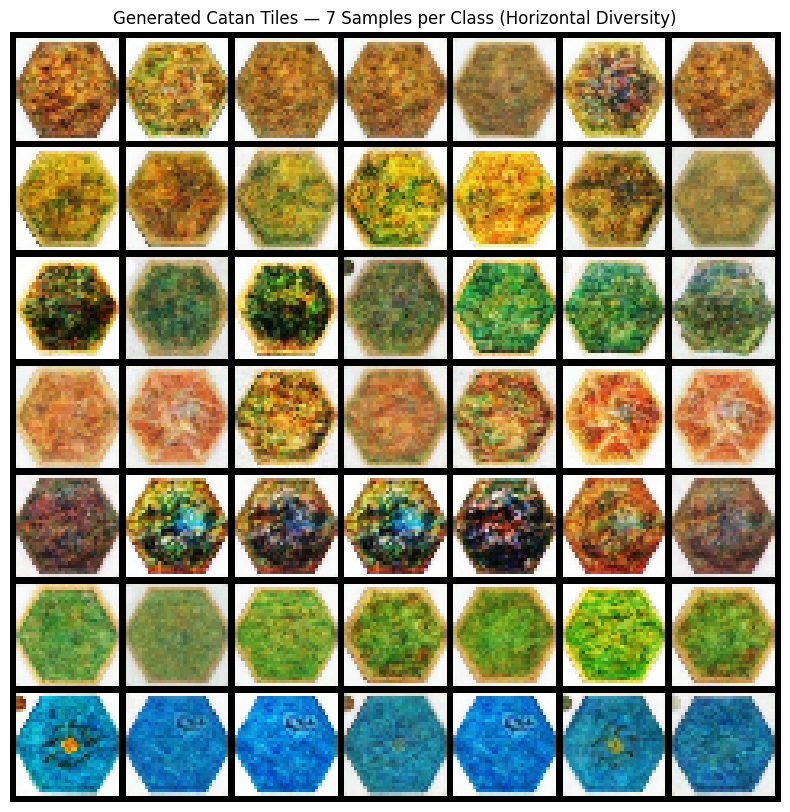

In [35]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torch

G.eval()
model.eval()

num_classes = 7
samples_per_class = 7

# Create labels: [0,0,0,...,1,1,1,...]
labels = torch.arange(num_classes, device=DEVICE).repeat_interleave(samples_per_class)

# Noise for each sample
noise = torch.randn(len(labels), LATENT_DIM, device=DEVICE)

with torch.no_grad():
    z = G(noise, labels)
    c = model.class_emb(labels)
    tiles = model.decoder(z, c)  # (N, 3, 32, 32)

# [-1,1] -> [0,1]
tiles = (tiles + 1) / 2
tiles = tiles.clamp(0, 1)

# Grid: columns = classes, rows = samples per class
grid = make_grid(
    tiles,
    nrow=num_classes,   # each column is a class
    padding=2
)

plt.figure(figsize=(14, 10))
plt.imshow(grid.permute(1, 2, 0).cpu())
plt.axis("off")
plt.title("Generated Catan Tiles — 7 Samples per Class (Horizontal Diversity)")
plt.show()

In [40]:
CLASS_NAMES = {
    0: "Fields",
    1: "Desert",
    2: "Forest",
    3: "Hills",
    4: "Mountains",
    5: "Pasture",
    6: "Sea",
}

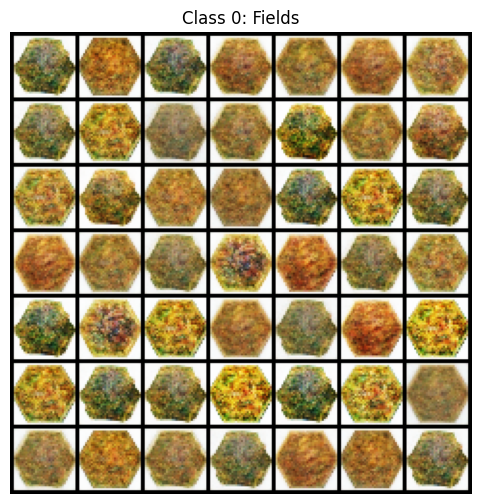

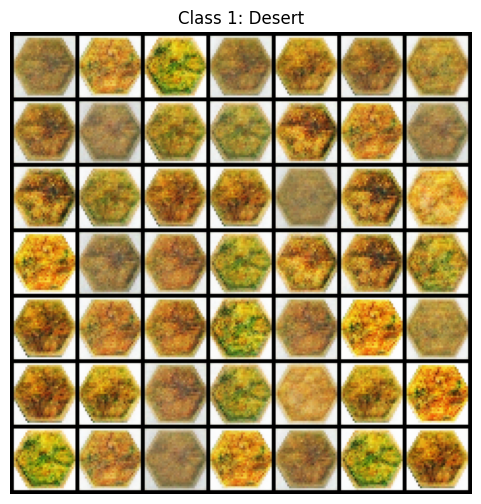

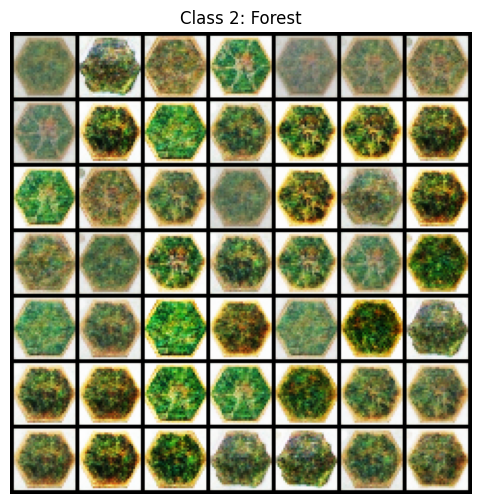

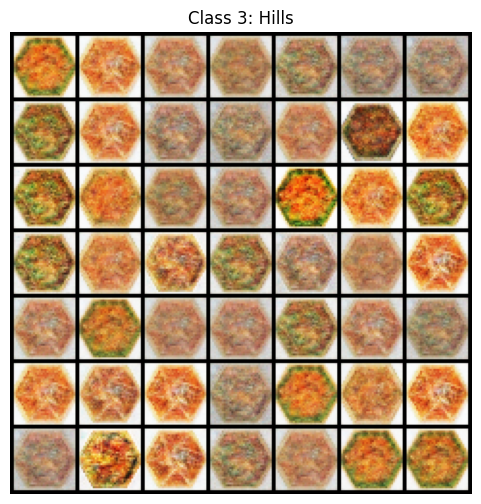

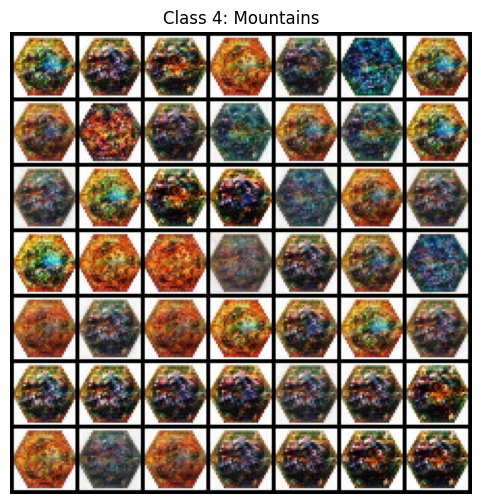

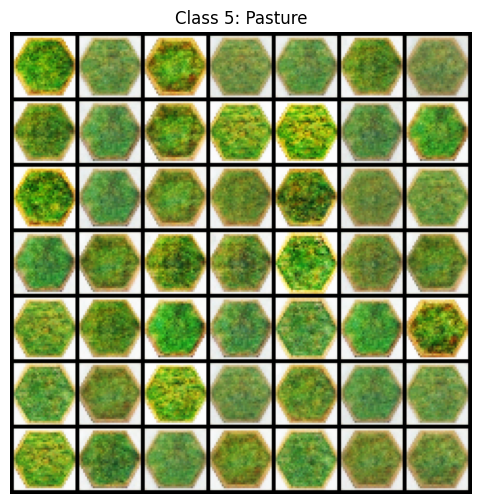

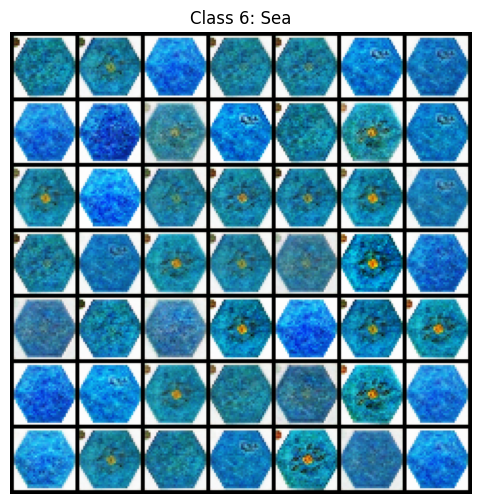

In [41]:

import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torch

G.eval()
model.eval()

grid_size = 7
samples_per_class = grid_size * grid_size

for class_idx, class_name in CLASS_NAMES.items():
    labels = torch.full(
        (samples_per_class,),
        class_idx,
        device=DEVICE,
        dtype=torch.long
    )

    noise = torch.randn(samples_per_class, LATENT_DIM, device=DEVICE)

    with torch.no_grad():
        z = G(noise, labels)
        c = model.class_emb(labels)
        tiles = model.decoder(z, c)  # (49, 3, 32, 32)

    # [-1, 1] → [0, 1]
    tiles = (tiles + 1) / 2
    tiles = tiles.clamp(0, 1)

    grid = make_grid(
        tiles,
        nrow=grid_size,
        padding=2
    )

    plt.figure(figsize=(6, 6))
    plt.imshow(grid.permute(1, 2, 0).cpu())
    plt.axis("off")
    plt.title(f"Class {class_idx}: {class_name}")
    plt.show()

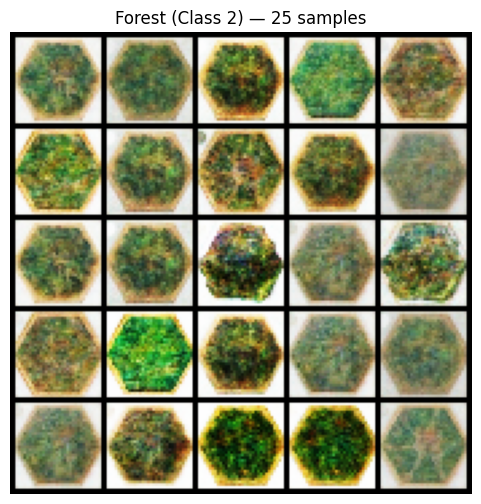

Saved 25 images to:
generation_sets/Forest_class2_20251217_031142


In [42]:
import os
from datetime import datetime
import torch
import matplotlib.pyplot as plt
from torchvision.utils import make_grid, save_image

# ==========================
# USER CONTROLS
# ==========================
HEX_CLASS = 2          # <-- class index to generate
NUM_GENERATE = 25      # <-- number of tiles to generate
GRID_NROW = 5          # visualization layout (sqrt-ish)

# ==========================
# CLASS MAPPING (SAFE)
# ==========================
CLASS_NAMES = {
    0: "Desert",
    1: "Hills",
    2: "Forest",
    3: "Fields",
    4: "Mountains",
    5: "Pasture",
    6: "Water",
}

hex_name = CLASS_NAMES[HEX_CLASS]

# ==========================
# OUTPUT FOLDER (TIMESTAMPED)
# ==========================
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
out_dir = f"generation_sets/{hex_name}_class{HEX_CLASS}_{timestamp}"
os.makedirs(out_dir, exist_ok=True)

# ==========================
# GENERATION
# ==========================
G.eval()
model.eval()

labels = torch.full(
    (NUM_GENERATE,),
    HEX_CLASS,
    device=DEVICE,
    dtype=torch.long
)

noise = torch.randn(NUM_GENERATE, LATENT_DIM, device=DEVICE)

with torch.no_grad():
    z = G(noise, labels)
    c = model.class_emb(labels)
    tiles = model.decoder(z, c)  # (N, 3, H, W)

# [-1, 1] -> [0, 1]
tiles = (tiles + 1) / 2
tiles = tiles.clamp(0, 1)

# ==========================
# DISPLAY GRID
# ==========================
grid = make_grid(
    tiles,
    nrow=GRID_NROW,
    padding=2
)

plt.figure(figsize=(6, 6))
plt.imshow(grid.permute(1, 2, 0).cpu())
plt.axis("off")
plt.title(f"{hex_name} (Class {HEX_CLASS}) — {NUM_GENERATE} samples")
plt.show()

# ==========================
# SAVE INDIVIDUAL IMAGES
# ==========================
for i, img in enumerate(tiles):
    save_image(
        img,
        os.path.join(out_dir, f"{hex_name}_{i:03d}.png")
    )

print(f"Saved {NUM_GENERATE} images to:\n{out_dir}")